In [ ]:
!pip install -q langchain langchain-community langgraph duckduckgo-search tavily-python serpapi ddgs google-search-results langchain-tavily


In [ ]:
from typing import Dict, Any, TypedDict, List
from langchain_tavily import TavilySearch
import requests
from bs4 import BeautifulSoup
import time
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.vectorstores import FAISS
from langchain_community.tools.ddg_search.tool import DuckDuckGoSearchResults
from langchain_community.utilities import SerpAPIWrapper
from langgraph.graph import StateGraph, END
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.prompts import PromptTemplate
from langchain_google_genai import GoogleGenerativeAIEmbeddings

In [ ]:
import os
from google.colab import userdata
os.environ["SERPAPI_API_KEY"]=userdata.get('SERPAPI_API_KEY')
os.environ["TAVILY_API_KEY"]=userdata.get('TAVILY_API_KEY')
os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')

In [ ]:
class AgentState(TypedDict):
    """
    Represents the state of our search agent graph.

    Attributes:
        query: The search query.
        result: The result from a successful search.
        error_message: Any error message encountered during a search attempt.
        successful_agent: The name of the agent that successfully returned a result.
    """
    query: str
    result: Any
    error_message: str
    successful_agent: str
    documents: List[str]  # To store scraped content
    retrieved_context: str # To store relevant chunks
    final_answer: str

def tavily_agent(state:AgentState) -> Dict[str, Any]:
  """This node perfoms web search using Tavily agent. This is the primary preferred agent."""
  try:
    tavily_tool = TavilySearch(max_results=5)
    result = tavily_tool.invoke({"query" : state["query"]})
    print("Tavily raw result:", result)
    return {"result": result, "successful_agent": "Tavily"}
  except Exception as e:
    print(f"Tavily Search failed: {e}")
    return {"result" : None, "succesful_agent" : None, "error_message" : str(e)}

def ddg_agent(state: AgentState) -> Dict[str, Any]:
    """Fallback: This node performs web search using DuckDuckGo search agent if Tavily fails."""
    try:
        ddg_tool = DuckDuckGoSearchResults(max_results=5)
        result = ddg_tool.invoke({"query": state["query"]})
        return {"result": result, "successful_agent": "DuckDuckGo", "error_message": None}
    except Exception as e:
        print(f"DuckDuckGo Search failed: {e}")
        return {"result": None, "successful_agent": None, "error_message": str(e)}

def serpapi_agent(state: AgentState) -> Dict[str, Any]:
    """Fallback: This node performs web search using SerpAPI (Google) if Tavily and DuckDuckGo fail."""
    try:
        serpapi_tool = SerpAPIWrapper()
        result = serpapi_tool.run(state["query"])
        return {"result": result, "successful_agent": "SerpAPI", "error_message": None}
    except Exception as e:
        print(f"SerpAPI Search failed: {e}")
        return {"result": None, "successful_agent": None, "error_message": str(e)}

def web_search_agent(state: AgentState) -> Dict[str, Any]:
    """Tries agents in order: Tavily -> DuckDuckGo -> SerpAPI"""
    for agent_fn in [tavily_agent, ddg_agent, serpapi_agent]:
        response = agent_fn(state)
        if response["result"] is not None:
            return response  # return first successful result
    return {"result": None, "successful_agent": None, "error_message": "All search agents failed"}



def scrape_urls_node(state: AgentState) -> AgentState:
    """Scrapes the content from the URLs found in the search result."""
    print("--- Scraping Content ---")
    scraped_docs = []
    urls = [res['url'] for res in state["result"]["results"]]

    for url in urls:
        try:
            response = requests.get(url, timeout=10)
            soup = BeautifulSoup(response.content, 'html.parser')
            # Extract text and clean it up
            text = soup.get_text().strip()
            text = " ".join(text.split())
            scraped_docs.append(text)
        except Exception as e:
            print(f"Failed to scrape {url}: {e}")

    return {**state, "documents": scraped_docs}


def rag_node(state: AgentState) -> AgentState:
    """Performs RAG on the scraped documents using Gemini embeddings with rate limiting."""
    print("--- Performing RAG with Gemini Embeddings ---")

    # --- BATCHING & RATE LIMITING LOGIC ---

    # 1. Initialize the embedding model
    embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

    # 2. Split documents into chunks
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
    chunks = text_splitter.split_text(" ".join(state["documents"]))

    # 3. Create the vector store by embedding chunks in batches
    batch_size = 100  # The Gemini API has a batch size limit
    vectorstore = None

    for i in range(0, len(chunks), batch_size):
        batch = chunks[i:i + batch_size]
        if vectorstore is None:
            # Create the store with the first batch
            vectorstore = FAISS.from_texts(batch, embedding=embeddings)
        else:
            # Add subsequent batches to the existing store
            vectorstore.add_texts(batch)

        print(f"Embedded batch {i//batch_size + 1}/{(len(chunks) - 1)//batch_size + 1}")
        time.sleep(1) # Pause for 1 second between batches to respect rate limits

    # --- END OF BATCHING LOGIC ---

    retriever = vectorstore.as_retriever()
    relevant_chunks = retriever.get_relevant_documents(state["query"])
    context = "\n\n".join([doc.page_content for doc in relevant_chunks])

    return {**state, "retrieved_context": context}

def generate_answer_node(state: AgentState) -> AgentState:
    """Generates a final answer using the retrieved context."""
    print("--- Generating Final Answer with LLM ---")
    prompt_template = """Based on the following context, please provide a concise answer to the question.

    Context:
    {context}

    Question:
    {question}
    """
    prompt = PromptTemplate(
        template=prompt_template,
        input_variables=["context", "question"],
    )

    llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0.7)

    chain = prompt | llm
    answer = chain.invoke({
        "context": state["retrieved_context"],
        "question": state["query"]
    })

    return {**state, "final_answer": answer.content}

In [ ]:
def tavily_node(state: AgentState) -> AgentState:
    # Pass the whole state dictionary, not just the query string
    response = tavily_agent(state)
    return {**state, **response}

def ddg_node(state: AgentState) -> AgentState:
    # Pass the whole state dictionary
    response = ddg_agent(state)
    return {**state, **response}

def serp_node(state: AgentState) -> AgentState:
    # Pass the whole state dictionary
    response = serpapi_agent(state)
    return {**state, **response}

In [ ]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(AgentState)

workflow.add_node("tavily", tavily_node)
workflow.add_node("duckduckgo", ddg_node)
workflow.add_node("serpapi", serp_node)
workflow.add_node("scrape_urls", scrape_urls_node)
workflow.add_node("rag", rag_node)
workflow.add_node("generate_answer", generate_answer_node)

workflow.set_entry_point("tavily")


workflow.add_conditional_edges(
    "tavily",
    lambda s: "fail" if s.get("error_message") else "success",
    {
        "success": "scrape_urls",
        "fail": "duckduckgo"
    },
)

workflow.add_conditional_edges(
    "duckduckgo",
    lambda s: "fail" if s.get("error_message") else "success",
    {
        "success": "scrape_urls",
        "fail": "serpapi"
    },
)

workflow.add_conditional_edges(
    "serpapi",
     lambda s: "fail" if s.get("error_message") else "success",
    {
        "success": "scrape_urls",
        "fail": END
    },
)


workflow.add_edge("scrape_urls", "rag")
workflow.add_edge("rag", "generate_answer")
workflow.add_edge("generate_answer", END)

graph = workflow.compile()


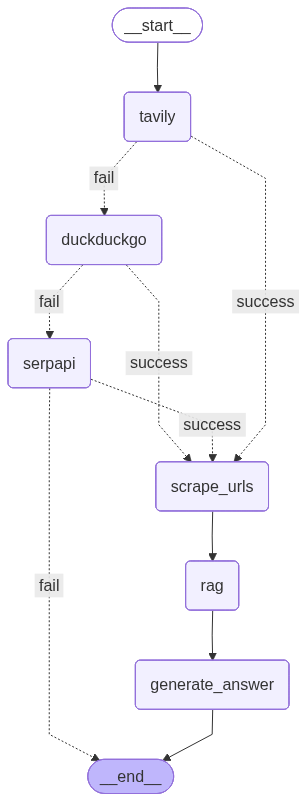

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
initial_state = {"query": "What is the latest news in quantum computing?"}
final_state = graph.invoke(initial_state)
print("\\n--- FINAL ANSWER ---")
print(final_state["final_answer"])

Tavily raw result: {'query': 'What is the latest news in quantum computing?', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://phys.org/tags/quantum+computing/', 'title': 'Quantum Computing - latest research news and features', 'content': 'News on quantum computing · MRI technology inspires quantum advancement with 2D materials · How to build larger, more reliable quantum computers, even with', 'score': 0.78944516, 'raw_content': None}, {'url': 'https://thequantuminsider.com/', 'title': 'The Quantum Insider: Quantum Computing News & Top Stories', 'content': 'Quantum National News · French National Quantum Update: August 2025 · EU Gives Greater Access to Quantum Computers to Accelerate Next-Generation Technology.', 'score': 0.78670514, 'raw_content': None}, {'url': 'https://www.bbc.com/news/topics/cyz9ex69xwlt', 'title': 'Quantum computing - BBC News', 'content': "State-of-the-art quantum computer switched on. Dr Chris Ballance says the new quantum

In [ ]:
!pip install -q langchain-google-genai beautifulsoup4 faiss-cpu